# Constructing The Model

## Imports

In [1]:
import cv2
import IPython.display as ipd
import keras
import librosa # Compatible with python 3.10
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, Reshape
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

2025-04-05 11:20:41.660047: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 11:20:41.695269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Constants

#### Directories

In [2]:
# Assign paths
base_dir = "dataset"

# Use for-norm dataset
train_dir = os.path.join(base_dir, "for-norm", "for-norm", "training")
test_dir = os.path.join(base_dir, "for-norm", "for-norm", "testing")
val_dir = os.path.join(base_dir, "for-norm", "for-norm", "validation")

# Classified directories
train_dir_fake = os.path.join(train_dir, "fake")
train_dir_real = os.path.join(train_dir, "real")
test_dir_fake = os.path.join(test_dir, "fake")
test_dir_real = os.path.join(test_dir, "real")
val_dir_fake = os.path.join(val_dir, "fake")
val_dir_real = os.path.join(val_dir, "real")

In [3]:
# Check for mistakes
print("Base directory:", base_dir)
print()
print("Train directory:", train_dir)
print("Test directory:", test_dir)
print("Val directory:", val_dir)
print()
print("Train (fake) directory:", train_dir_fake)
print("Train (real) directory:", train_dir_real)
print("Test (fake) directory:", test_dir_fake)
print("Test (real) directory:", test_dir_real)
print("Val (fake) directory:", val_dir_fake)
print("Val (real) directory:", val_dir_real)

Base directory: dataset

Train directory: dataset/for-norm/for-norm/training
Test directory: dataset/for-norm/for-norm/testing
Val directory: dataset/for-norm/for-norm/validation

Train (fake) directory: dataset/for-norm/for-norm/training/fake
Train (real) directory: dataset/for-norm/for-norm/training/real
Test (fake) directory: dataset/for-norm/for-norm/testing/fake
Test (real) directory: dataset/for-norm/for-norm/testing/real
Val (fake) directory: dataset/for-norm/for-norm/validation/fake
Val (real) directory: dataset/for-norm/for-norm/validation/real


#### Other Constants

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 12
EPOCHS = 20
STEPS_PER_EPOCH = 300

## Obtain Data

In [5]:
# Obtain waveform (.wav) audio files
train_fake_audio_path = [os.path.join(train_dir_fake, file) for file in os.listdir(train_dir_fake) if file.endswith(".wav")]
train_real_audio_path = [os.path.join(train_dir_real, file) for file in os.listdir(train_dir_real) if file.endswith(".wav")]

test_fake_audio_path = [os.path.join(test_dir_fake, file) for file in os.listdir(test_dir_fake) if file.endswith(".wav")]
test_real_audio_path = [os.path.join(test_dir_real, file) for file in os.listdir(test_dir_real) if file.endswith(".wav")]

validation_fake_audio_path = [os.path.join(val_dir_fake, file) for file in os.listdir(val_dir_fake) if file.endswith(".wav")]
validation_real_audio_path = [os.path.join(val_dir_real, file) for file in os.listdir(val_dir_real) if file.endswith(".wav")]

In [6]:
# Convert audio file to spectrogram
# def create_spectrogram(file_path):
#     audio_data, sample_rate = librosa.load(file_path)
#     spectrogram = librosa.stft(audio_data)
#     decibel_spectrogram = librosa.amplitude_to_db(abs(spectrogram))
#     return decibel_spectrogram

# Convert audio file to mel-scale spectrogram
# See https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
def create_mel_spectrogram(file_path):
    audio_data, sample_rate = librosa.load(file_path)  
    # Convert audio to mel-based spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    # Convert from amplitude squared to decibel units
    mel_decibel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  
    return mel_decibel_spectrogram

In [7]:
# Use spectrograms as features to train the model
def get_features_and_labels(real_audio_files, fake_audio_files):
    spec_arr = []
    labels = []

    target_shape = (128, 87) # Target shape for resizing

    for file in real_audio_files:
        spectrogram = create_mel_spectrogram(file)
        resized_spectrogram = cv2.resize(spectrogram, target_shape[::-1], interpolation=cv2.INTER_LINEAR) # Resize, swap width and height
        spec_arr.append(resized_spectrogram)
        labels.append(0)
    for file in fake_audio_files:
        spectrogram = create_mel_spectrogram(file)
        resized_spectrogram = cv2.resize(spectrogram, target_shape[::-1], interpolation=cv2.INTER_LINEAR) # Resize, swap width and height
        spec_arr.append(resized_spectrogram)
        labels.append(1)


    return np.array(spec_arr), np.array(labels)

In [ ]:
train_features, train_labels = get_features_and_labels(train_real_audio_path, train_fake_audio_path)
validation_features, validation_labels = get_features_and_labels(validation_real_audio_path, validation_fake_audio_path)
test_features, test_labels = get_features_and_labels(test_real_audio_path, test_fake_audio_path)

In [ ]:
# Verity the shapes of the features
print("train features shape: {}".format(train_features.shape))
print("test features shape: {}".format(test_features.shape))

train features shape: (53868, 128, 87)
test features shape: (4634, 128, 87)


In [ ]:
# Significantly trimmed VGG model to optimize results

trimmed_vgg = Sequential()
trimmed_vgg.add(Reshape((128, 87, 1),input_shape=train_features.shape[1:]))

trimmed_vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

trimmed_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

trimmed_vgg.add(Flatten())
trimmed_vgg.add(Dense(units=256,activation="relu"))
trimmed_vgg.add(Dense(units=256,activation="relu"))
trimmed_vgg.add(Dense(1, activation="sigmoid"))

trimmed_vgg.summary()

/home/pooh/miniconda3/envs/audio_classification/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1743786445.611940   23973 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743786445.830714   23973 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743786445.832402   23973 cuda_executor.cc:1015] success

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 128, 87, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 87, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 87, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 43, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86016)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,020,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,345,409 (85.24 MB)

 Trainable params: 22,345,409 (85.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
# Adam optimiser helps model get unstuck when stuck at local minima
trimmed_vgg.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.binary_crossentropy, 
                    metrics=["accuracy"])

In [ ]:
trimmed_vgg_history = trimmed_vgg.fit(train_features,
                                      train_labels,
                                      validation_data = [validation_features, validation_labels],
                                      batch_size = BATCH_SIZE,
                                      epochs = EPOCHS,
                                      steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9895 - loss: 0.0268 - val_accuracy: 0.9885 - val_loss: 0.0535
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9813 - loss: 0.0661 - val_accuracy: 0.9931 - val_loss: 0.0200
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9926 - loss: 0.0254 - val_accuracy: 0.9931 - val_loss: 0.0209
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9898 - loss: 0.0339 - val_accuracy: 0.9959 - val_loss: 0.0105
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9962 - loss: 0.0154 - val_accuracy: 0.9979 - val_loss: 0.0066
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9976 - loss: 0.0077 - val_accuracy: 0.9906 - val_loss: 0.0278
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9967 - loss: 0.0131 - val_accuracy: 0.9973 - val_loss: 0.0075
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9910 - loss: 0.0314 - val_acc

2025-04-05 00:13:16.826590: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-05 00:13:16.826613: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6303829441131759109
2025-04-05 00:13:16.826622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2550465506661631726
/home/pooh/miniconda3/envs/audio_classification/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9960 - loss: 0.0134 - val_accuracy: 0.9950 - val_loss: 0.0123
Epoch 13/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9960 - loss: 0.0103 - val_accuracy: 0.9950 - val_loss: 0.0143
Epoch 14/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9973 - loss: 0.0074 - val_accuracy: 0.9880 - val_loss: 0.0389
Epoch 15/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9930 - loss: 0.0218 - val_accuracy: 0.9983 - val_loss: 0.0051
Epoch 16/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9981 - loss: 0.0091 - val_accuracy: 0.9967 - val_loss: 0.0095
Epoch 17/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9958 - loss: 0.0093 - val_accuracy: 0.9970 - val_loss: 0.0101
Epoch 18/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9959 - loss: 0.0113 - val_accuracy: 0.9943 - val_loss: 0.0179
Epoch 19/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9983 - loss: 0.0049 - val_accuracy

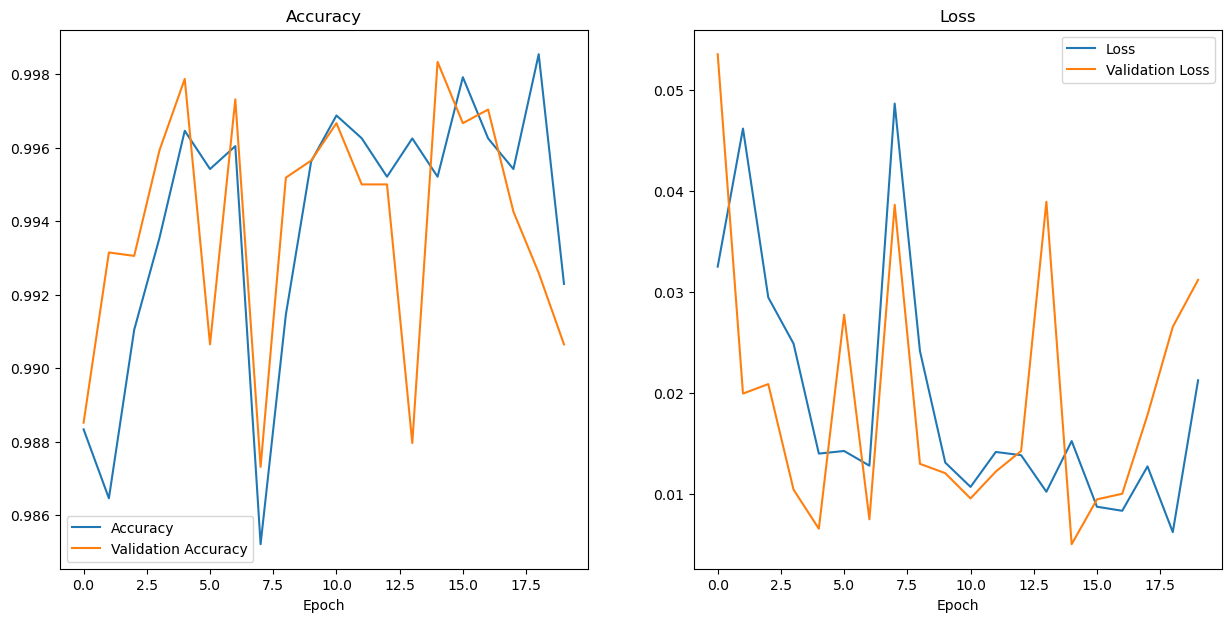

In [ ]:
# Note that extremely high accuracy is not due to model overfitting,
# it's because the dataset is very "easy" relative to actual modern state of deepfaked audio
# i.e. the fakes are mostly easily detectable, even to the human ear

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.plot(trimmed_vgg_history.history["accuracy"])
ax1.plot(trimmed_vgg_history.history['val_accuracy'])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Accuracy","Validation Accuracy"])

ax2.plot(trimmed_vgg_history.history["loss"])
ax2.plot(trimmed_vgg_history.history["val_loss"])
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Loss","Validation Loss"])

plt.show()

In [ ]:
trimmed_vgg_loss, trimmed_vgg_accuracy = trimmed_vgg.evaluate(test_features, test_labels)

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8788 - loss: 0.4384


In [ ]:
# Saving the final version
trimmed_vgg.save("../../trained_models/deepfake_audio_detector_2.h5")